### Objective

In this notebook, we train a neural network model to predict Rth

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, max_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from pathlib import Path

import tensorflow as tf
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='tensorflow')

%matplotlib inline
np.set_printoptions(precision=4,suppress=True)

In [2]:
df = pd.read_csv('./Dataset/TcTj_train.csv', header=None)
df.columns = ['Q1', 'Q2', 'd', 'b', 'L', 'c', 'L_duct', 'n', 't', 'xc1', 'yc1', 'xc2', 'yc2', 'Tc', 'Tj', 'w']
print(f"Pool: {df.shape[0]}")

Pool: 9421


In [3]:
# Remove outliers
df = df[df.Tj<250].reset_index(drop=True)
print(f"Filtered pol: {df.shape[0]}")

Filtered pol: 9386


In [4]:
# Dedicated testing set
df_test = pd.read_csv('./Dataset/TcTj_test.csv', header=None)
df_test.columns = ['Q1', 'Q2', 'd', 'b', 'L', 'c', 'L_duct', 'n', 't', 'xc1', 'yc1', 'xc2', 'yc2', 'Tc', 'Tj', 'w']

# Remove outliers
df_test = df_test[df_test.Tj<250].reset_index(drop=True)
print(f"Filtered testing pol: {df_test.shape[0]}")

Filtered testing pol: 9375


In [5]:
def create_samples(df, train_num):
   
    # Create dataset
    X = df.iloc[:, :-3].to_numpy()
    y = df.iloc[:, -2].to_numpy()
    
    # Train-test split
    if train_num < len(df):
        test_size = 1-train_num/len(df)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    else:
        X_train, y_train = X, y
        X_test, y_test = None, None
    
    return X_train, X_test, y_train, y_test

In [6]:
# Train-test split
X_train, _, y_train, _ = create_samples(df, 9000)
X_test, _, y_test, _ = create_samples(df_test, 9000)

# Data scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Define the model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation='selu', kernel_initializer='LecunNormal', input_shape=(13,)),
  tf.keras.layers.Dense(20, activation="selu", kernel_initializer='LecunNormal'),
    tf.keras.layers.Dense(20, activation="selu", kernel_initializer='LecunNormal'),
    # tf.keras.layers.Dense(5, activation="selu", kernel_initializer='LecunNormal'),
  tf.keras.layers.Dense(1)
])

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                280       
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1141 (4.46 KB)
Trainable params: 1141 (4.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=200)   
optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-2)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

with tf.device("CPU:0"):
    
    # Model training
    history = model.fit(X_train_scaled, y_train, epochs=1000, batch_size=128, 
             validation_split=0.2, callbacks=[lr_scheduler])

Epoch 1/1000

57/57 [==============================] - 1s 4ms/step - loss: 4900.6313 - val_loss: 198.5980 - lr: 0.0100
Epoch 2/1000
57/57 [==============================] - 0s 2ms/step - loss: 152.7438 - val_loss: 135.6986 - lr: 0.0100
Epoch 3/1000
57/57 [==============================] - 0s 2ms/step - loss: 120.0255 - val_loss: 111.0690 - lr: 0.0100
Epoch 4/1000
57/57 [==============================] - 0s 2ms/step - loss: 102.9161 - val_loss: 100.7113 - lr: 0.0100
Epoch 5/1000
57/57 [==============================] - 0s 2ms/step - loss: 93.4965 - val_loss: 95.7110 - lr: 0.0100
Epoch 6/1000
57/57 [==============================] - 0s 2ms/step - loss: 87.7815 - val_loss: 96.2540 - lr: 0.0100
Epoch 7/1000
57/57 [==============================] - 0s 2ms/step - loss: 83.4857 - val_loss: 87.9508 - lr: 0.0100
Epoch 8/1000
57/57 [==============================] - 0s 2ms/step - loss: 80.7964 - val_loss: 86.8980 - lr: 0.0100
Epoch 9/1000
57/57 [==============================] - 0s 2ms/step - lo

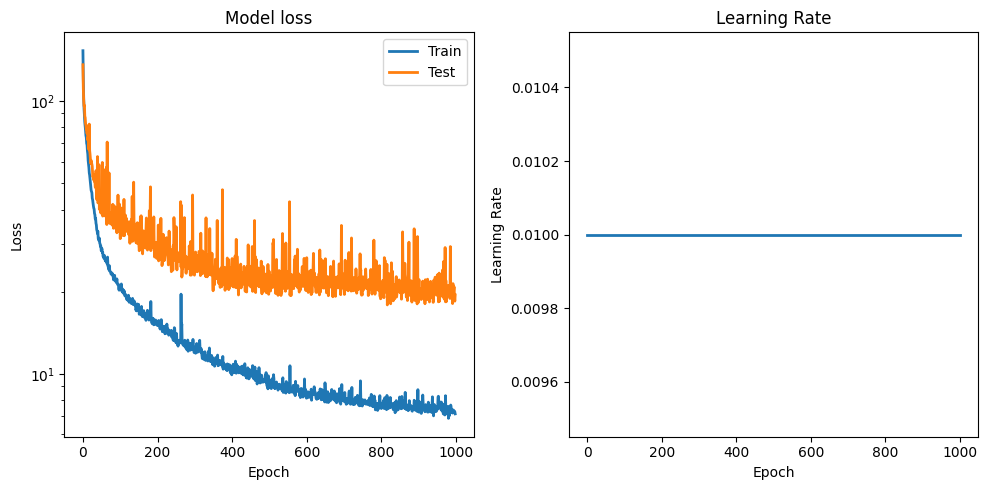

In [9]:
fig, (ax_1, ax_2) = plt.subplots(1,2,figsize=(10,5))
ax_1.plot(history.history['loss'][1:], linewidth=2, label='Train')
ax_1.plot(history.history['val_loss'][1:], linewidth=2, label='Test')
ax_1.set_yscale('log')
ax_1.legend(loc='upper right')
ax_1.set_title('Model loss')
ax_1.set_ylabel('Loss')
ax_1.set_xlabel('Epoch')

ax_2.plot(history.history['lr'], linewidth=2)
ax_2.set_title('Learning Rate')
ax_2.set_ylabel('Learning Rate')
ax_2.set_xlabel('Epoch')

plt.tight_layout()

In [10]:
def evaluate_model(y_true, y_pred):
    """This function is used for evaluating the ML models performance."""
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    max_e = max_error(y_true, y_pred)
    
    percentage = np.abs(y_true-y_pred)/y_true
    max_percentage = np.max(percentage)*100
    max_percentage_loc = np.argmax(percentage)
    median_percentage = np.median(percentage)*100
    mean_percentage = np.mean(percentage)*100
    
    return rmse, max_e, max_percentage, max_percentage_loc, median_percentage, mean_percentage

#### Predict on testing dataset

In [11]:
%%time

y_pred = model.predict(X_test_scaled).flatten()
rmse, max_e, max_per, _, median_per, mean_per = evaluate_model(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"Max Error: {max_e:.4f}")
print(f"Max Percentage Error: {max_per:.2f}")
print(f"Median Percentage Error: {median_per:.2f}")
print(f"Mean Percentage Error: {mean_per:.2f}")

282/282 [==============================] - 0s 836us/step
RMSE: 4.2728
Max Error: 85.1178
Max Percentage Error: 56.22
Median Percentage Error: 1.78
Mean Percentage Error: 2.41
CPU times: total: 531 ms
Wall time: 517 ms


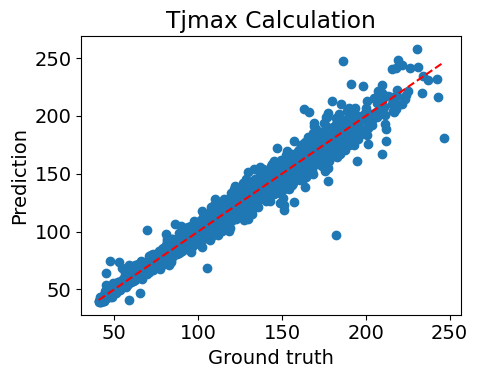

In [12]:
# Set the default font size
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(y_test, y_pred, 'o')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax.set_title('Tjmax Calculation')
ax.set_xlabel('Ground truth')
ax.set_ylabel('Prediction')

plt.tight_layout()